In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation,BatchNormalization,Input,Embedding,Dot,Dense,Flatten
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler,TensorBoard,EarlyStopping

from wordcloud import WordCloud
%matplotlib inline

### Reading ANIMELIST.CSV

In [3]:
import os

In [4]:
INPUT_DIR=os.path.join("..","artifacts","raw")

In [5]:
rating_df=pd.read_csv(INPUT_DIR+"/animelist.csv",low_memory=True,usecols=["user_id","anime_id","rating"])

In [6]:
rating_df.head()

,user_id,anime_id,rating
0,0,67,9
1,0,6702,7
2,0,242,10
3,0,4898,0
4,0,21,10


In [7]:
rating_df.shape

(7000000, 3)

### DATA PROCESSING

In [8]:
n_ratings=rating_df["user_id"].value_counts()

In [9]:
n_ratings

user_id
20807    17546
11100    14429
22022    13696
16869     8943
10255     8403
         ...  
13606        1
15566        1
9020         1
17067        1
26           1
Name: count, Length: 21103, dtype: int64

In [10]:
rating_df=rating_df[rating_df["user_id"].isin(n_ratings[n_ratings>400].index)].copy()

In [11]:
rating_df

,user_id,anime_id,rating
213,2,24833,0
214,2,235,10
215,2,36721,0
216,2,40956,0
217,2,31933,0
...,...,...,...
6999995,22944,4214,0
6999996,22944,2000,0
6999997,22944,64,0
6999998,22944,65,0


In [12]:
min_rating=min(rating_df["rating"])
min_rating

0

In [13]:
max_rating=max(rating_df["rating"])
max_rating

10

In [14]:
avg_rating=np.mean(rating_df["rating"])
avg_rating

np.float64(4.072611611849041)

In [15]:
#doing scaling for rating column (Min-Max Scaling)
rating_df["rating"]=rating_df["rating"].apply(lambda x: (x-min_rating)/(max_rating-min_rating)).values.astype(np.float64)


In [16]:
np.mean(rating_df["rating"])

np.float64(0.407261161184904)

In [17]:
## Checking duplicates
rating_df.duplicated().sum()

np.int64(0)

In [18]:
### Checking for null values
rating_df.isnull().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

In [19]:
#User to user encoding for our model
### userid--->10056 ----->97

user_ids=rating_df["user_id"].unique().tolist()
user2user_encoded={x : i for i,x in enumerate(user_ids)}
user2user_decoded={i : x for i,x in enumerate(user_ids)}
rating_df["user"]=rating_df["user_id"].map(user2user_encoded) #creates another oclumn of user encoded for machine

In [20]:
rating_df

,user_id,anime_id,rating,user
213,2,24833,0.0,0
214,2,235,1.0,0
215,2,36721,0.0,0
216,2,40956,0.0,0
217,2,31933,0.0,0
...,...,...,...,...
6999995,22944,4214,0.0,5828
6999996,22944,2000,0.0,5828
6999997,22944,64,0.0,5828
6999998,22944,65,0.0,5828


In [21]:
n_users=len(user2user_encoded)
n_users

5829

In [22]:
## Doing same for anime_id column


anime_ids=rating_df["anime_id"].unique().tolist()
anime2anime_encoded={x : i for i,x in enumerate(anime_ids)}
anime2anime_decoded={i : x for i,x in enumerate(anime_ids)}
rating_df["anime"]=rating_df["anime_id"].map(anime2anime_encoded) #creates another oclumn of user encoded for machine

In [23]:
rating_df

,user_id,anime_id,rating,user,anime
213,2,24833,0.0,0,0
214,2,235,1.0,0,1
215,2,36721,0.0,0,2
216,2,40956,0.0,0,3
217,2,31933,0.0,0,4
...,...,...,...,...,...
6999995,22944,4214,0.0,5828,1574
6999996,22944,2000,0.0,5828,5417
6999997,22944,64,0.0,5828,727
6999998,22944,65,0.0,5828,730


In [24]:
n_anime=len(anime2anime_encoded)
n_anime

17553

In [25]:
## Shuffling data so that our model learns pattern on random data.LearningRateScheduler 
rating_df=rating_df.sample(frac=1,random_state=43).reset_index(drop=True)

In [26]:
rating_df

,user_id,anime_id,rating,user,anime
0,16418,21797,0.0,4167,2247
1,21090,16051,0.0,5368,2196
2,781,7060,0.0,206,10547
3,21935,31139,0.0,5576,4302
4,7048,37999,0.9,1763,1482
...,...,...,...,...,...
4553275,5929,3011,0.6,1479,6087
4553276,7928,30014,0.0,2002,3188
4553277,7522,777,0.9,1896,193
4553278,12688,38524,0.7,3201,405


In [27]:
X=rating_df[["user","anime"]].values
y=rating_df["rating"]

In [28]:
test_size=1000
train_indices=rating_df.shape[0]-test_size

In [29]:
X_train,X_test,y_train,y_test=(
    X[:train_indices],
    X[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

In [30]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((4552280, 2), (1000, 2), (4552280,), (1000,))

In [31]:
type(X_train)

numpy.ndarray

In [32]:
#Storing the input features as a list
X_train_array=[X_train[:,0],X_train[:,1]]
X_test_array=[X_test[:,0],X_test[:,1]]

In [33]:
type(X_test_array)

list

### MODEL ARCHITECTURE

In [34]:
def RecommendorNet():
    embeddiing_size=128  #no of vectors

    user=Input(name="user",shape=[1])

    user_embedding=Embedding(name="user_embedding",input_dim=n_users,output_dim=embeddiing_size)(user) #the embedding layer would be working on input layer

    anime=Input(name="anime",shape=[1])

    anime_embedding=Embedding(name="anime_embedding",input_dim=n_anime,output_dim=embeddiing_size)(anime)

    x=Dot(name="dot_product",normalize=True,axes=2)([user_embedding,anime_embedding]) #similarities between user and anime

    x=Flatten()(x) #Convertws high dimensional vector into single dimensional vector

    x=Dense(1,kernel_initializer="he_normal")(x)
    x=BatchNormalization()(x)
    x=Activation("sigmoid")(x)

    model=Model(inputs=[user,anime],outputs=x)
    model.compile(loss="binary_crossentropy",metrics=["mae","mse"],optimizer="Adam")

    return model


In [35]:
model=RecommendorNet()

In [36]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 128)    │    746,112 │ user[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime_embedding     │ (None, 1, 128)    │  2,246,784 │ anime[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_product (Dot)   │ (None, 1, 1)      │          0 │ user_embedding[0… │
│                     │                   │            │ anime_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1)         │          0 │ dot_product[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │          2 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1)         │          4 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1)         │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,992,902 (11.42 MB)

 Trainable params: 2,992,900 (11.42 MB)

 Non-trainable params: 2 (8.00 B)

In [37]:
start_lr=0.00001
min_lr=0.0001
max_lr=0.00005
batch_size=10000

ramup_epochs=5
sustain_epochs=0
exp_decay=0.8

#for finding best learning rate for our model
def lrfn(epoch):
    if epoch<ramup_epochs:
        return (max_lr-start_lr)/ramup_epochs*epoch+start_lr
    elif epoch<ramup_epochs+sustain_epochs:
        return max_lr
    else:
        return (max_lr-min_lr)*exp_decay**(epoch-ramup_epochs-sustain_epochs)+min_lr

In [38]:
lr_callback=LearningRateScheduler(lambda epoch:lrfn(epoch),verbose=0)
checkpoint_filepath='./weights.weights.h5'

model_checkpoint=ModelCheckpoint(filepath=checkpoint_filepath,save_weights_only=True,monitor="val_loss",mode="min",save_best_only=True)

early_stopping=EarlyStopping(patience=3,monitor="val_loss",mode="min",restore_best_weights=True)

In [39]:
my_callbacks=[model_checkpoint,lr_callback,early_stopping]

In [40]:
import os
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

import tensorflow as tf

history=model.fit(
    x=X_train_array,
    y=y_train,
    batch_size=batch_size,
    epochs=20,
    verbose=1,
    validation_data=(X_test_array,y_test),
    callbacks=my_callbacks
)

Epoch 1/20
 84/456 ━━━━━━━━━━━━━━━━━━━━ 32s 88ms/step - loss: 0.6931 - mae: 0.3620 - mse: 0.1566

456/456 ━━━━━━━━━━━━━━━━━━━━ 70s 146ms/step - loss: 0.6931 - mae: 0.3620 - mse: 0.1565 - val_loss: 0.6927 - val_mae: 0.3687 - val_mse: 0.1593 - learning_rate: 1.0000e-05
Epoch 2/20
456/456 ━━━━━━━━━━━━━━━━━━━━ 83s 161ms/step - loss: 0.6925 - mae: 0.3620 - mse: 0.1563 - val_loss: 0.6913 - val_mae: 0.3687 - val_mse: 0.1587 - learning_rate: 1.8000e-05
Epoch 3/20
456/456 ━━━━━━━━━━━━━━━━━━━━ 53s 111ms/step - loss: 0.6917 - mae: 0.3622 - mse: 0.1559 - val_loss: 0.6907 - val_mae: 0.3687 - val_mse: 0.1584 - learning_rate: 2.6000e-05
Epoch 4/20
456/456 ━━━━━━━━━━━━━━━━━━━━ 45s 98ms/step - loss: 0.6903 - mae: 0.3620 - mse: 0.1552 - val_loss: 0.6888 - val_mae: 0.3685 - val_mse: 0.1574 - learning_rate: 3.4000e-05
Epoch 5/20
456/456 ━━━━━━━━━━━━━━━━━━━━ 44s 96ms/step - loss: 0.6855 - mae: 0.3596 - mse: 0.1528 - val_loss: 0.6743 - val_mae: 0.3569 - val_mse: 0.1503 - learning_rate: 4.2000e-05
Epoch 6/20
456/456 ━━━━━━━━━━━━━━━━━━━━ 54s 118ms/step - loss: 0.6497 - mae: 0.3338 - mse: 0.1355 - val_loss

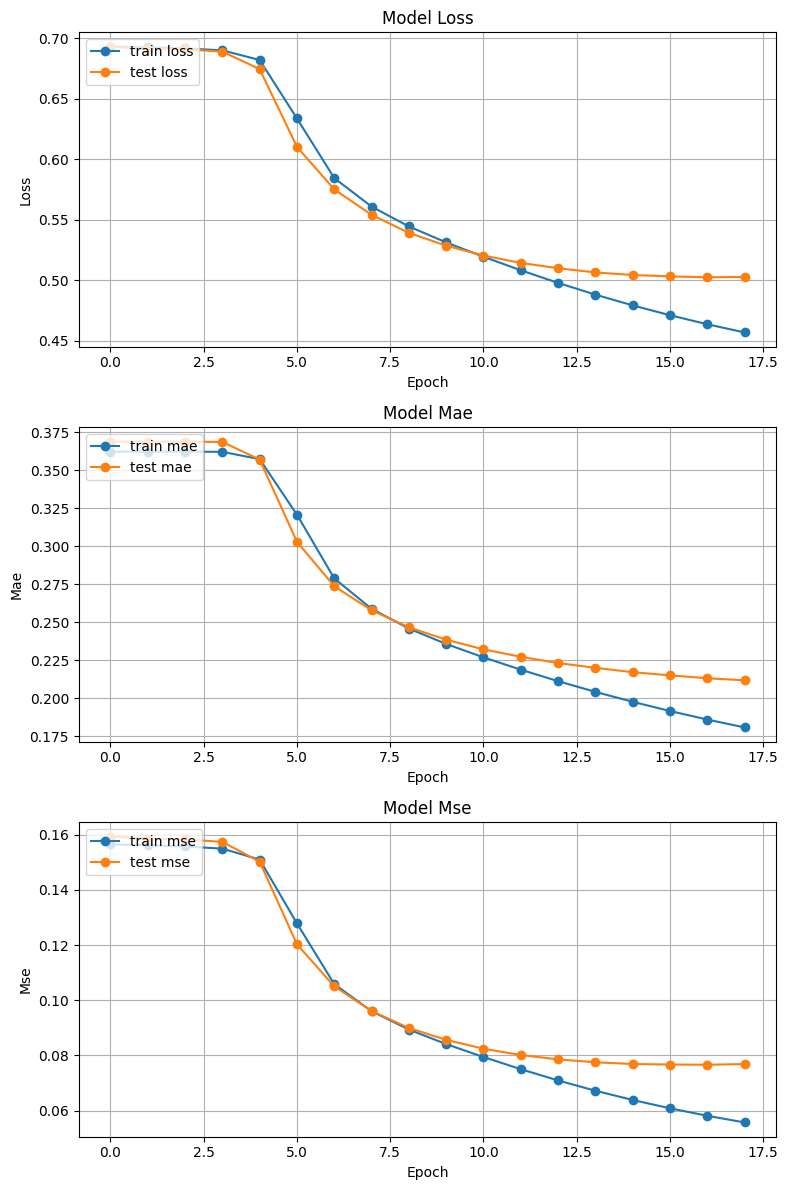

In [41]:
metrics=["loss","mae","mse"]

fig,axes=plt.subplots(len(metrics),1,figsize=(8,len(metrics)*4))

for i,metric in enumerate(metrics):
    ax=axes[i]
    ax.plot(history.history[metric][0:-2],marker="o",label=f"train {metric}")
    ax.plot(history.history[f"val_{metric}"][0:-2],marker="o",label=f"test {metric}")
    ax.set_title(f"Model {metric.capitalize()}")
    ax.set_ylabel(metric.capitalize())
    ax.set_xlabel("Epoch")
    ax.legend(loc="upper left")
    ax.grid(True)

plt.tight_layout()
plt.show()

In [42]:
def extract_weights(name,model):
    weight_layer=model.get_layer(name)
    weights=weight_layer.get_weights()[0]
    weights=weights/np.linalg.norm(weights,axis=1,keepdims=True)
    return weights

In [43]:
# import joblib
# model=joblib.load("model.pkl")

In [44]:
anime_weights=extract_weights("anime_embedding",model)

In [45]:
anime_weights

array([[ 3.20102535e-02,  6.85424730e-02, -5.84986843e-02, ...,
        -4.43045273e-02, -6.38241763e-04,  9.30216834e-02],
       [ 8.86578951e-03,  3.37225311e-02,  6.85137883e-02, ...,
         2.48381700e-02, -6.48988485e-02,  7.28260353e-02],
       [ 4.77608033e-02,  1.31576732e-01, -5.51584028e-02, ...,
        -3.11500076e-02, -7.36922398e-03, -4.08865562e-05],
       ...,
       [-2.89620627e-02,  1.14097595e-01,  2.35629920e-03, ...,
        -1.00680135e-01,  9.01039466e-02,  1.13752261e-01],
       [ 2.80923359e-02,  1.75087690e-01, -3.96075398e-02, ...,
        -9.04535279e-02, -5.04317321e-02,  1.31739810e-01],
       [ 4.00037728e-02, -5.52606732e-02, -2.87231803e-02, ...,
         1.23929836e-01,  6.20656908e-02,  7.32579976e-02]], dtype=float32)

In [46]:
user_weights=extract_weights("user_embedding",model)

In [47]:
user_weights

array([[ 0.02002692, -0.02645974,  0.04836234, ..., -0.05751888,
         0.04576797,  0.1092412 ],
       [ 0.01211906, -0.00188118, -0.04111103, ..., -0.07337104,
         0.04597786, -0.11134177],
       [-0.09794509,  0.01558756,  0.00185723, ..., -0.02841931,
        -0.06783082,  0.03227106],
       ...,
       [ 0.05267559, -0.01045132, -0.10311549, ...,  0.11376422,
        -0.04385295,  0.0067493 ],
       [-0.04838808, -0.03733455, -0.16954978, ...,  0.1172567 ,
        -0.01141104,  0.1761118 ],
       [-0.05283621,  0.057425  , -0.06208665, ..., -0.03322374,
         0.08218426,  0.11488267]], dtype=float32)

#### READING ANIME>CSV

In [48]:
df=pd.read_csv(INPUT_DIR+"/anime.csv",low_memory=True)

In [49]:
df.head()

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,50229.0,75651.0,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,...,2182.0,4806.0,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,...,312.0,529.0,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0


In [50]:

df=df.replace("Unknown",np.nan)

In [51]:
def getAnimeName(anime_id):
    #Creates a sepeartecolumn for english version of anime name and where the value is np.nan it stores the Name column value
    try:
        name=df[df.anime_id==anime_id].eng_version.values[0] 
        if name is np.nan:
            name=df[df.anime_id==anime_id].Name.values[0]
    
    except:
        print("Error")
    return name

In [52]:
df["anime_id"]=df["MAL_ID"]#sameas MAL_ID
df["eng_version"]=df["English name"]
df["eng_version"]=df.anime_id.apply(lambda x: getAnimeName(x))

In [53]:
df.head(2)

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,anime_id,eng_version
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0,1,Cowboy Bebop
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",NaN,...,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0,5,Cowboy Bebop:The Movie


In [54]:
getAnimeName(2045)

'Mahou no Tenshi Creamy Mami: Eien no Once More'

In [55]:
df.sort_values(by=["Score"],
               inplace=True,
               ascending=False,
               kind="quicksort",
               na_position="last")


In [56]:
df.head(2)

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,anime_id,eng_version
3971,5114,Fullmetal Alchemist: Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Ma...",Fullmetal Alchemist:Brotherhood,鋼の錬金術師 FULLMETAL ALCHEMIST,TV,64,"Apr 5, 2009 to Jul 4, 2010",Spring 2009,...,199160.0,70045.0,20210.0,9308.0,3222.0,1536.0,2162.0,16806.0,5114,Fullmetal Alchemist:Brotherhood
15926,40028,Shingeki no Kyojin: The Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",Attack on Titan Final Season,進撃の巨人 The Final Season,TV,16,"Dec 7, 2020 to ?",Winter 2021,...,26016.0,8793.0,2674.0,1336.0,588.0,382.0,514.0,11061.0,40028,Attack on Titan Final Season


In [57]:
#Feature Selection
df.columns

Index(['MAL_ID', 'Name', 'Score', 'Genres', 'English name', 'Japanese name',
       'Type', 'Episodes', 'Aired', 'Premiered', 'Producers', 'Licensors',
       'Studios', 'Source', 'Duration', 'Rating', 'Ranked', 'Popularity',
       'Members', 'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped',
       'Plan to Watch', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6',
       'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1', 'anime_id',
       'eng_version'],
      dtype='object')

In [58]:
df=df[["anime_id","eng_version","Score","Genres","Episodes","Type","Premiered","Members"]]

In [59]:
df.head(1)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
3971,5114,Fullmetal Alchemist:Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Ma...",64,TV,Spring 2009,2248456


In [60]:
def  getAnimeFrame(anime,df):
    """
    A fuction to get the frame of anime when a user provides anime_id or anime_name
    """
    if isinstance(anime,int):
        return df[df.anime_id==anime]
    if isinstance(anime,str):
        return df[df.eng_version==anime]

In [61]:
getAnimeFrame("Attack on Titan Final Season",df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",16,TV,Winter 2021,733260


In [62]:
getAnimeFrame(40028,df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",16,TV,Winter 2021,733260


irrespective of what user provides anime_id or anime name the model will return thee framem

#### Anime_WITH_SYNOPSIS.CSV

In [63]:
cols=["MAL_ID","Name","Genres","sypnopsis"]

In [64]:
synopsis_df=pd.read_csv(INPUT_DIR+"/anime_with_synopsis.csv",usecols=cols)

In [81]:
synopsis_df.head(1)

,MAL_ID,Name,Genres,sypnopsis
0,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized several of the planets and moons of the solar system leaving the now uninhabitable surface of planet Earth behind. The Inter Solar System Police attempts to keep peace in the galaxy, aided in part by outlaw bounty hunters, referred to as ""Cowboys."" The ragtag team aboard the spaceship Bebop are two such individuals. Mellow and carefree Spike Spiegel is balanced by his boisterous, pragmatic partner Jet Black as the pair makes a living chasing bounties and collecting rewards. Thrown off course by the addition of new members that they meet in their travels—Ein, a genetically engineered, highly intelligent Welsh Corgi; femme fatale Faye Valentine, an enigmatic trickster with memory loss; and the strange computer whiz kid Edward Wong—the crew embarks on thrilling adventures that unravel each member's dark and mysterious past little by little. Well-balanced with high density action and light-hearted comedy, Cowboy Bebop is a space Western classic and an homage to the smooth and improvised music it is named after."


In [75]:
#We want to get the sypnopsis of anime whenever the user passes the anime_id or name
def getSynopsis(anime,df):
    if isinstance(anime,int):
        return synopsis_df[synopsis_df.MAL_ID==anime].sypnopsis.values[0]
    if isinstance(anime,str):
        return synopsis_df[synopsis_df.Name==anime].sypnopsis.values[0]

In [76]:
getSynopsis(40028,df)

"Gabi Braun and Falco Grice have been training their entire lives to inherit one of the seven titans under Marley's control and aid their nation in eradicating the Eldians on Paradis. However, just as all seems well for the two cadets, their peace is suddenly shaken by the arrival of Eren Yeager and the remaining members of the Survey Corps. Having finally reached the Yeager family basement and learned about the dark history surrounding the titans, the Survey Corps has at long last found the answer they so desperately fought to uncover. With the truth now in their hands, the group set out for the world beyond the walls. In Shingeki no Kyojin: The Final Season , two utterly different worlds collide as each party pursues its own agenda in the long-awaited conclusion to Paradis' fight for freedom."

In [77]:
getSynopsis("Steins;Gate",df)

'The self-proclaimed mad scientist Rintarou Okabe rents out a room in a rickety old building in Akihabara, where he indulges himself in his hobby of inventing prospective "future gadgets" with fellow lab members: Mayuri Shiina, his air-headed childhood friend, and Hashida Itaru, a perverted hacker nicknamed "Daru." The three pass the time by tinkering with their most promising contraption yet, a machine dubbed the "Phone Microwave," which performs the strange function of morphing bananas into piles of green gel. Though miraculous in itself, the phenomenon doesn\'t provide anything concrete in Okabe\'s search for a scientific breakthrough; that is, until the lab members are spurred into action by a string of mysterious happenings before stumbling upon an unexpected success—the Phone Microwave can send emails to the past, altering the flow of history. Adapted from the critically acclaimed visual novel by 5pb. and Nitroplus, Steins;Gate takes Okabe through the depths of scientific theory 

### CONTENT/ITEM BASED RECOMMENDATION SYSTEM

In [82]:
pd.set_option("max_colwidth",None) #displays the whole content of the column

In [106]:
def find_similar_animes(name,anime_weights,anime2anime_encoded,
                        anime2anime_decoded,df,synopsis_df,n=10,return_dist=False,neg=False):
    try:
        index=getAnimeFrame(name,df).anime_id.values[0] #gets the index value of anime
        encoded_index=anime2anime_encoded.get(index) #gets the encoded index for model

        if encoded_index is None:
            raise ValueError(f"Encoded index not found for anime ID: {index}")

        weights=anime_weights

        dists=np.dot(weights,weights[encoded_index]) #getes similarities between weights of all animes and encoded one anime  in form of vector and then sorts it from decending
        sorted_dists=np.argsort(dists)
        n=n+1 #because we want to include anime also

        if neg: #if user wants the dissimaliar recommendations of the anime
            closest=sorted_dists[:n]
        else:
            closest=sorted_dists[-n:]
        
        print(f"Anime closest to {name}")

        if return_dist:
            return dists,closest
        
        SimilarityArr=[]

        for close in closest:
            decoded_id=anime2anime_decoded.get(close)
            
            synopsis=getSynopsis(decoded_id,synopsis_df)
            
            anime_frame=getAnimeFrame(decoded_id,df)
            
            anime_name=anime_frame.eng_version.values[0]
            
            genre=anime_frame.Genres.values[0]
            
            similarity=dists[close]
            
            SimilarityArr.append({
                "anime_id" : decoded_id,
                "name" : anime_name,
                "similarity" : similarity,
                "genre" : genre,
                "synopsis" : synopsis
            })

        Frame=pd.DataFrame(SimilarityArr).sort_values(by="similarity",ascending=False)
        return Frame[Frame.anime_id != index].drop(["anime_id"],axis=1)
        
    except:
        print("Error occured")




In [105]:
find_similar_animes(
    "Steins;Gate",
    anime_weights,
    anime2anime_encoded,
    anime2anime_decoded,
    df,
    synopsis_df,
    n=2 #no. of recommendations
)

Anime closest to Steins;Gate


,name,similarity,genre,synopsis
1,Code Geass:Lelouch of the Rebellion R2,0.723759,"Action, Military, Sci-Fi, Super Power, Drama, Mecha","One year has passed since the Black Rebellion, a failed uprising against the Holy Britannian Empire led by the masked vigilante Zero, who is now missing. At a loss without their revolutionary leader, Area 11's resistance group—the Black Knights—find themselves too powerless to combat the brutality inflicted upon the Elevens by Britannia, which has increased significantly in order to crush any hope of a future revolt. Lelouch Lamperouge, having lost all memory of his double life, is living peacefully alongside his friends as a high school student at Ashford Academy. His former partner C.C., unable to accept this turn of events, takes it upon herself to remind him of his past purpose, hoping that the mastermind Zero will rise once again to finish what he started, in this thrilling conclusion to the series."
0,Fate/Zero Season 2,0.710833,"Action, Supernatural, Magic, Fantasy","s the Fourth Holy Grail War rages on with no clear victor in sight, the remaining Servants and their Masters are called upon by Church supervisor Risei Kotomine, in order to band together and confront an impending threat that could unravel the Grail War and bring about the destruction of Fuyuki City. The uneasy truce soon collapses as Masters demonstrate that they will do anything in their power, no matter how despicable, to win. Seeds of doubt are sown between Kiritsugu Emiya and Saber, his Servant, as their conflicting ideologies on heroism and chivalry clash. Meanwhile, an ominous bond forms between Kirei Kotomine, who still seeks to find his purpose in life, and one of the remaining Servants. As the countdown to the end of the war reaches zero, the cost of winning begins to blur the line between victory and defeat."


In [ ]:
getAnimeFrame